In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

/home/mpheng/workspace/reinforcement_learning/reinforcement_learning_playground/reinforcement-learning/env/lib/python3.10/site-packages/gym/__init__.py


In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [6]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        A = np.zeros_like(Q[observation], dtype=float)
        best_action = np.argmax(Q[observation])
        A[best_action] = 1.0
    return policy_fn

In [9]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))

    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for i_episode in range(1, num_episodes + 1):
        # Reset the environment to start a new episode
        state = env.reset()
        episode = []

        # Generate an episode using the behavior policy
        for t in range(100):  # Limit the maximum number of steps to 100
            # Get action probabilities from the behavior policy
            action_probs = behavior_policy(state)

            # Sample an action based on the behavior policy's probabilities
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            # Take the action in the environment and observe the outcome
            next_state, reward, done, _ = env.step(action)

            # Store the (state, action, reward) tuple in the episode
            episode.append((state, action, reward))

            # If the episode is over, stop generating further steps
            if done:
                break

            # Move to the next state
            state = next_state

        # At this point, the entire episode is generated and stored in `episode`

        # Initialize the discounted return
        G = 0.0

        # Initialize the importance sampling weight
        W = 1.0

        # Process the episode in reverse order
        for state, action, reward in reversed(episode):
            # Compute the discounted return
            G = discount_factor * G + reward

            # Update the cumulative sum of weights (normalization term)
            C[state][action] += W

            # Update the action-value function Q(s, a) using weighted importance sampling
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])

            # Check if the action taken is not the greedy action under the current target policy
            if action != np.argmax(target_policy(state)):
                # If the action is not part of the greedy target policy, stop further updates
                break

            # Update the importance sampling weight for the next step
            # Scale it by the ratio of target policy probability to behavior policy probability
            W *= 1.0 / behavior_policy(state)[action]

    return Q, target_policy

In [10]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

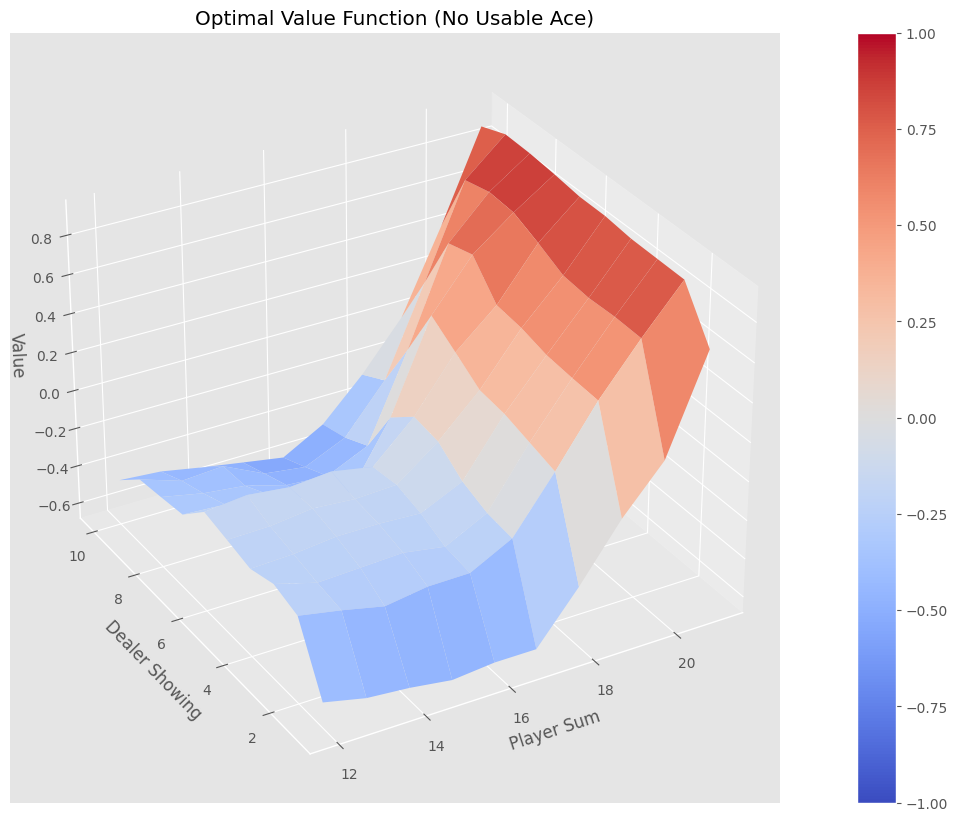

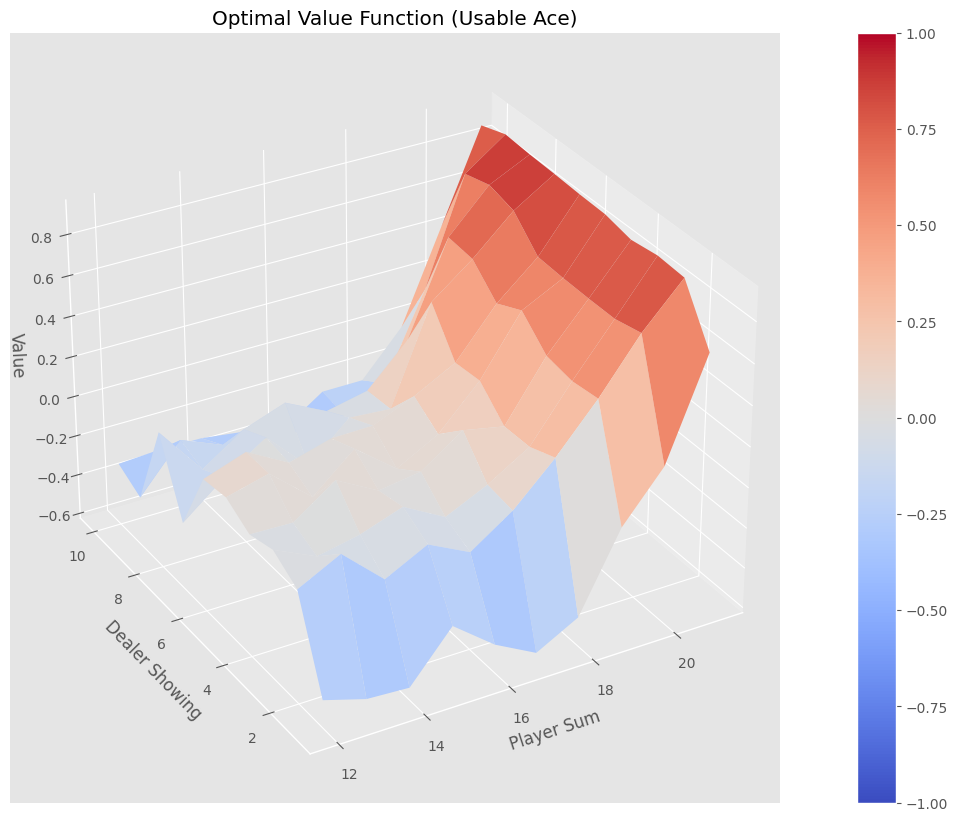

In [11]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")